In [ ]:
# math libraries
import numpy as np

# ml libraries
import tensorflow as tf
from keras import layers, models, optimizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import mnist, cifar10
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, Concatenate, Multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks

# visualization
import skimage
from skimage import data, color, exposure
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

# sys and helpers
import sys
import os
import glob
from tqdm import tqdm

print('Modules imported.')



# device check
from tensorflow.python.client import device_lib
print('Devices:', device_lib.list_local_devices())

# GPU check
if not tf.test.gpu_device_name():
    print('No GPU found.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

Modules imported.
Devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16658717063289241272
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14415560704
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9001143415603596005
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


# Loading the data

In [ ]:
def load_dataset(dataset, width, height, channels):
    
    if dataset == 'mnist':
        # load MNIST data
        (X_train, y_train), (X_test, y_test) = mnist.load_data()

        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        X_train = np.expand_dims(X_train, axis=3)
        
    if dataset == 'cifar10':
        # load CIFAR10 data
        (X_train, y_train), (X_test, y_test) = cifar10.load_data()

        # rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        
        
    # defining input dims
    img_rows = width
    img_cols = height
    channels = channels
    img_shape = [img_rows, img_cols, channels]
    
    return X_train, img_shape
    

# if MNIST ('mnist', 28, 28, 1) if CIFAR10 ('cifar10', 32, 32, 3)
dataset, shape = load_dataset('cifar10', 32, 32, 3)
print('Dataset shape: {0}, Image shape: {1}'.format(dataset.shape, shape))

Dataset shape: (50000, 32, 32, 3), Image shape: [32, 32, 3]


## Helper functions for Capsule layers

In [ ]:
# squash function of capsule layers, borrowed from Xifeng Guo's implementation of Keras CapsNet `https://github.com/XifengGuo/CapsNet-Keras`
def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

## Defining the model

In [ ]:
# discriminator structure
def build_discriminator():

    """
    This is the part my 'Capsule Layer as a Discriminator in Generative Adversarial Networks' paper focuses on,
    as it introduces a new structure to the discriminator of DCGAN by using Capsule Layers architecture from original
    'Dynamic Routing Between Capsules' paper by S. Sabour, N. Frosst and G. Hinton.
    
    Discriminator takes real/generated images and outputs its prediction.
    """

    # depending on dataset we define input shape for our network
    img = Input(shape=(shape[0], shape[1], shape[2]))

    # first typical convlayer outputs a 20x20x256 matrix
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv1')(img)
    x = LeakyReLU()(x)
    
    # original 'Dynamic Routing Between Capsules' paper does not include the batch norm layer after the first conv group
    x = BatchNormalization(momentum=0.8)(x)

    
    """
    NOTE: Capsule architecture starts from here.
    """
    #
    # primarycaps coming first
    #
    
    # filters 256 (n_vectors=8 * channels=32)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    
    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    
    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)


    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.
    
    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    x = Flatten()(x)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)

    print(x.shape)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    
    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)


    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    pred = Dense(1, activation='sigmoid')(s_j)

    
    return Model(img, pred)

In [ ]:
# build and compile the discriminator
discriminator = build_discriminator()
print('DISCRIMINATOR:')
discriminator.summary()
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

(None, 16384)
DISCRIMINATOR:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 24, 24, 256)  62464       ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 24, 24, 256)  0           ['conv1[0][0]']                  
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 24, 256)  1024       ['leaky_re_lu[0][0]']            
 alization)                                                      

In [ ]:
# generator structure
def build_generator():

    """
    Generator follows the DCGAN architecture and creates generated image representations through learning.
    """

    noise_shape = (100,)
    x_noise = Input(shape=noise_shape)
    
    x = Dense(128 * 7 * 7, activation="relu")(x_noise)
    x = Reshape((7, 7, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)

    """
    NOTE: Capsule architecture starts from here.
    """
    #
    # primarycaps coming first
    #
    
    # filters 256 (n_vectors=8 * channels=32)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    
    # reshape into the 8D vector for all 32 feature maps combined
    # (primary capsule has collections of activations which denote orientation of the digit
    # while intensity of the vector which denotes the presence of the digit)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    
    # the purpose is to output a number between 0 and 1 for each capsule where the length of the input decides the amount
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)


    #
    # digitcaps are here
    #
    """
    NOTE: My approach is a simplified version of digitcaps i.e. without expanding dimensions into
    [None, 1, input_n_vectors, input_dim_capsule (feature maps)]
    and tiling it into [None, num_capsule, input_n_vectors, input_dim_capsule (feature maps)].
    Instead I replace it with ordinary Keras Dense layers as weight holders in the following lines.
    
    ANY CORRECTIONS ARE APPRECIATED IN THIS PART, PLEASE SUBMIT PULL REQUESTS!
    """
    x = Flatten()(x)
    # capsule (i) in a lower-level layer needs to decide how to send its output vector to higher-level capsules (j)
    # it makes this decision by changing scalar weight (c=coupling coefficient) that will multiply its output vector and then be treated as input to a higher-level capsule
    #
    # uhat = prediction vector, w = weight matrix but will act as a dense layer, u = output from a previous layer
    # uhat = u * w
    # neurons 160 (num_capsules=10 * num_vectors=16)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    
    # c = coupling coefficient (softmax over the bias weights, log prior) | "the coupling coefficients between capsule (i) and all the capsules in the layer above sum to 1"
    # we treat the coupling coefficiant as a softmax over bias weights from the previous dense layer
    c = Activation('softmax', name='softmax_digitcaps1')(uhat) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    
    # s_j (output of the current capsule level) = uhat * c
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    """
    NOTE: Squashing the capsule outputs creates severe blurry artifacts, thus we replace it with Leaky ReLu.
    """
    s_j = LeakyReLU()(x)


    #
    # we will repeat the routing part 2 more times (num_routing=3) to unfold the loop
    #
    c = Activation('softmax', name='softmax_digitcaps2')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    c = Activation('softmax', name='softmax_digitcaps3')(s_j) # softmax will make sure that each weight c_ij is a non-negative number and their sum equals to one
    c = Dense(160)(c) # compute s_j
    x = Multiply()([uhat, c])
    s_j = LeakyReLU()(x)

    x = Dense(128 * 8 * 8, activation="relu")(s_j)
    x = Reshape((8, 8, 128))(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    
    x = Conv2D(160, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = UpSampling2D()(x)
    x = Conv2D(64, kernel_size=3, padding="same")(x)
    x = Activation("relu")(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(3, kernel_size=3, padding="same")(x)
    gen_out = Activation("tanh")(x)

      
    return Model(x_noise, gen_out)
   

In [ ]:
# build and compile the generator
generator = build_generator()
print('GENERATOR:')
generator.summary()
generator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5)) 

GENERATOR:
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 dense_4 (Dense)                (None, 6272)         633472      ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 7, 7, 128)    0           ['dense_4[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 7, 7, 128)   512         ['reshape[0][0]']                
 rmalization)                                                                    

In [ ]:
# feeding noise to generator
z = Input(shape=(100,))
img = generator(z)
print(img.shape)

(None, 32, 32, 3)


In [ ]:
# for the combined model we will only train the generator
discriminator.trainable = False

In [ ]:
# try to discriminate generated images
valid = discriminator(img)

In [ ]:
# the combined model (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 
combined = Model(z, valid)
print('COMBINED:')
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

COMBINED:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_1 (Functional)        (None, 32, 32, 3)         5333315   
                                                                 
 model (Functional)          (None, 1)                 8071233   
                                                                 
Total params: 13,404,548
Trainable params: 5,332,339
Non-trainable params: 8,072,209
_________________________________________________________________


## Training

In [ ]:
# loss values for further plotting
D_L_REAL = []
D_L_FAKE = []
D_L = []
D_ACC = []
G_L = []

In [ ]:
def train(dataset_title, epochs, batch_size=32, save_interval=50):

        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # select a random half batch of images
            idx = np.random.randint(0, dataset.shape[0], half_batch)
            imgs = dataset[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # train the discriminator by feeding both real and fake (generated) images one by one
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1))*0.9) # 0.9 for label smoothing
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)


            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # the generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = np.array([1] * 32)

            # train the generator
            g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))

            
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            D_L_REAL.append(d_loss_real)
            D_L_FAKE.append(d_loss_fake)
            D_L.append(d_loss)
            D_ACC.append(d_loss[1])
            G_L.append(g_loss)

            # if at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_imgs(dataset_title, epoch)

In [ ]:
def save_imgs(dataset_title, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, 100))
        gen_imgs = generator.predict(noise)

        # rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        # iterate in order to create a subplot
        for i in range(r):
            for j in range(c):
                if dataset_title == 'mnist':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                    axs[i,j].axis('off')
                    cnt += 1
                elif dataset_title == 'cifar10':
                    axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                    axs[i,j].axis('off')
                    cnt += 1
                else:
                    print('Please indicate the image options.')
        
        if not os.path.exists('images_{0}'.format(dataset_title)):
            os.makedirs('images_{0}'.format(dataset_title))
        
        fig.savefig("images_{0}/{1}.png".format(dataset_title, epoch))
        plt.close()

In [ ]:
history = train('cifar10', epochs=100, batch_size=32, save_interval=50)
#generator.save('mnist_model.h5')
generator.save('cifar10_model.h5')

1/1 [==============================] - 4s 4s/step
0 [D loss: 0.692979, acc.: 0.00%] [G loss: 0.693729]
1/1 [==============================] - 0s 26ms/step
1 [D loss: 0.690032, acc.: 0.00%] [G loss: 0.683486]
1/1 [==============================] - 0s 14ms/step
2 [D loss: 0.685921, acc.: 0.00%] [G loss: 0.643235]
1/1 [==============================] - 0s 20ms/step
3 [D loss: 0.675634, acc.: 50.00%] [G loss: 0.591087]
1/1 [==============================] - 0s 16ms/step
4 [D loss: 0.637381, acc.: 50.00%] [G loss: 0.475150]
1/1 [==============================] - 0s 15ms/step
5 [D loss: 0.566289, acc.: 50.00%] [G loss: 0.476943]
1/1 [==============================] - 0s 16ms/step
6 [D loss: 0.503125, acc.: 50.00%] [G loss: 0.850061]
1/1 [==============================] - 0s 15ms/step
7 [D loss: 0.428906, acc.: 50.00%] [G loss: 0.400173]
1/1 [==============================] - 0s 14ms/step
8 [D loss: 0.307453, acc.: 50.00%] [G loss: 0.382127]
1/1 [==============================] - 0s 15ms/step

## Visualizations

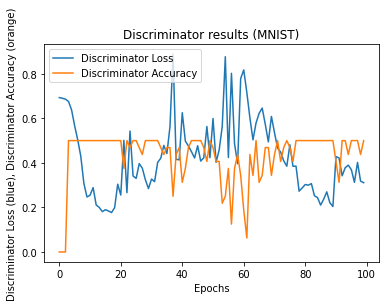

In [ ]:
plt.plot(D_L)
plt.title('Discriminator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Discriminator Loss (blue), Discriminator Accuracy (orange)')
plt.legend(['Discriminator Loss', 'Discriminator Accuracy'])
plt.show()

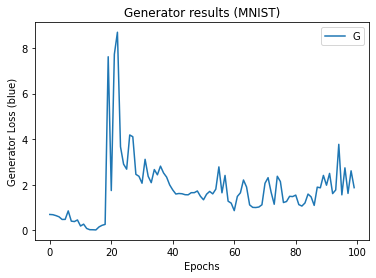

In [ ]:
plt.plot(G_L)
plt.title('Generator results (MNIST)')
plt.xlabel('Epochs')
plt.ylabel('Generator Loss (blue)')
plt.legend('Generator Loss')
plt.show()